## Import packages

In [1]:
import cv2
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

## Pre-define some global variables

In [2]:
BLUE = (255, 0, 0)
GREEN = (0, 255, 0)
RED = (0, 0, 255)

IMAGE_PATH = 'Images/gauge-1.jpg'

## Helper functions

### Show image functions

In [ ]:
def show_image(image, scale=1):
    windowName = 'Image'
    if scale != 1:
        cv2.namedWindow(windowName, cv2.WINDOW_NORMAL)
        cv2.resizeWindow(windowName, int(scale*image.shape[1]), int(scale*image.shape[0]))
    cv2.imshow(windowName, image)
    cv2.waitKey(0) 
    cv2.destroyAllWindows() 



def show_image_notebook(image, scale=1, title="Image"):
    rgbImage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    width = rgbImage.shape[1]
    height = rgbImage.shape[0]

    if scale != 1:
        plt.figure(figsize=(round(width*scale), round(height*scale)))
    plt.title(title)
    plt.imshow(rgbImage)
    plt.show()  

### Math functions

In [37]:
def calculate_distance_between_two_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)


# Get the distance between point p0 and a line p1 p2
# Use the formula: Line defined by two points (https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line)
def calcualte_distance_between_point_and_line(p1, p2, p0):
    return np.abs(np.cross(p2-p1, p1-p0)) / calculate_distance_between_two_points(p1, p2)


def calculate_pointer_angle(circleCenter, furthestPoint):
    zeroPointTransform = np.array([0, -circleCenter[1]])
    furthestPointTransform = furthestPoint - circleCenter

    cosTheta = np.dot(furthestPointTransform, zeroPointTransform) / (LA.norm(furthestPointTransform) * LA.norm(zeroPointTransform))
    angleRadian = np.arccos(cosTheta)

    if furthestPointTransform[0] < 0:
        angleRadian = 2*np.pi - angleRadian

    return np.rad2deg(angleRadian)
    

def read_dial(angleDegree, maxReading):
    reading = maxReading * angleDegree/360
    return np.around(reading, 2)
    



### Detect circle functions

In [ ]:
def detect_circles(grayImage, width, height, minDistance, minR, maxR):
    minDistance = np.around(minDistance)
    minR = np.around(minR)
    maxR = np.around(maxR)

    # dp=1 The accumulator matrix has the same size as the image
    # minDist: The minimum distance between two detected circles
    # param1: Upper threshold for the internal Canny edge detector
    # param2: The accumulator threshold for the circle centers at the detection stage
    circles = cv2.HoughCircles(grayImage, cv2.HOUGH_GRADIENT, dp=1, minDist=minDistance, param1=100, param2=100, minRadius=minR, maxRadius=maxR)

    return circles[0]



def draw_circles(image, circles):
    # `circles` is 2-D array
    resultImage = np.copy(image)
    for c in circles:
        centerX, centerY, radius = np.around(c).astype(int)
        # Draw the detected circle
        resultImage = cv2.circle(resultImage, (centerX, centerY), radius, GREEN, 2, cv2.LINE_AA)  
        # Draw the center
        resultImage = cv2.circle(resultImage, (centerX, centerY), 2, GREEN, 2, cv2.LINE_AA)  
    
    return resultImage



def get_average_circle(circles):
    # `circles` is 2-D array 
    averageCircle = np.average(circles, axis=0)
    return np.around(averageCircle).astype(int)

    



### Detect line functions

In [ ]:
def detect_lines(grayImage, minLength, maxGap):
    _, thresholdResultmage = cv2.threshold(grayImage, thresh=150, maxval=255, type=cv2.THRESH_BINARY_INV)

    # rho: Distance resolution of the accumulator in pixels
    # theta: Angle resolution of the accumulator in radians
    # threshold: Accumulator threshold parameter
    # minLineLength: Minimum line length
    # maxLineGap: Maximum allowed gap between points on the same line
    # lines = cv2.HoughLinesP(thresholdResultmage, rho=1, theta=np.pi/180, threshold=100, minLineLength=width//4, maxLineGap=0)
    lines = cv2.HoughLinesP(thresholdResultmage, rho=1, theta=np.pi/180, threshold=100, minLineLength=minLength, maxLineGap=maxGap)
    
    return np.squeeze(lines)



# Only the lines whose distance to the circle center is less than or equal to the threshold are valid
def filter_lines(lines, threshold, center):
    validLines = []
    for l in lines:
        p1 = np.array([l[0], l[1]])
        p2 = np.array([l[2], l[3]])

        distance = calcualte_distance_between_point_and_line(p1, p2, center)
        if distance <= threshold:
            validTwoPoints = np.array([p1, p2])
            validLines.append(validTwoPoints)

    return np.stack(validLines)



def draw_lines(image, lines):
    resultImage = np.copy(image)
    for l in lines:
        p1 = l[0]
        p2 = l[1]
        cv2.line(resultImage, (p1[0], p1[1]), (p2[0], p2[1]), GREEN, 1, cv2.LINE_AA)
    return resultImage


    

### Find the furthest point functions

In [ ]:
def find_furthest_point(validLines, center):
    validPoints = validLines.reshape((validLines.shape[0]*validLines.shape[1], validLines.shape[2]))
    transformResult = validPoints - center
    
    distanceArray = LA.norm(transformResult, axis=1)

    furthestPointTransform = transformResult[distanceArray.argmax()]
    furthestPoint = furthestPointTransform + center

    return np.around(furthestPoint).astype(int)


def draw_point(image, point):
    resultImage = np.copy(image)
    resultImage = cv2.circle(resultImage, (point[0], point[1]), 3, GREEN, 3, cv2.LINE_AA) 
    return resultImage

## Load gauge images

The size of the image: Height: [2199] px, Width: [1125] px


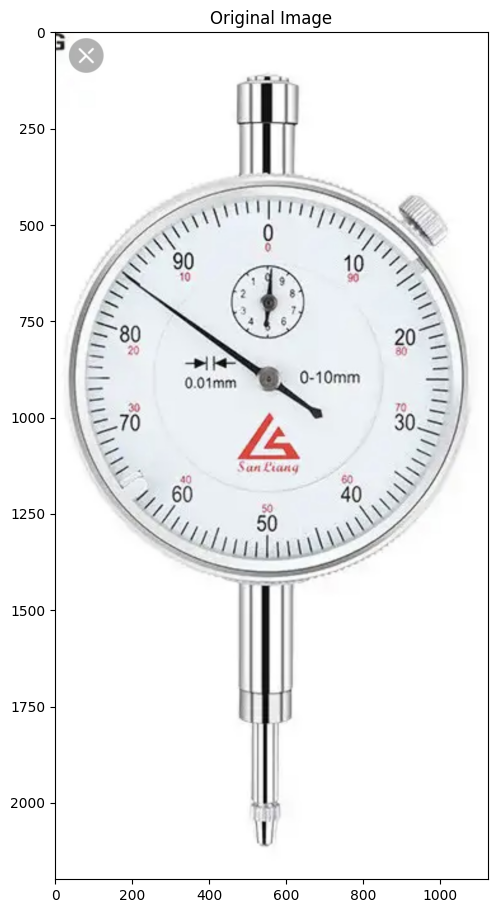

In [38]:
image = cv2.imread(IMAGE_PATH)
originalHeight, originalWidth = image.shape[0:2]
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print(f"The size of the image: Height: [{originalHeight}] px, Width: [{originalWidth}] px")

show_image_notebook(image, scale=1/200, title='Original Image')
# show_image(image, 0.5)

## Detect the circle of the dial

[[553.5 898.5 501. ]]


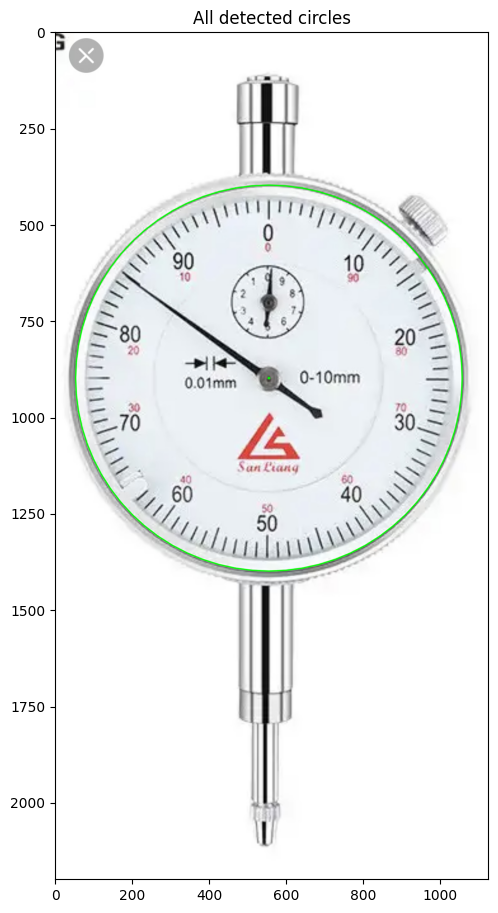

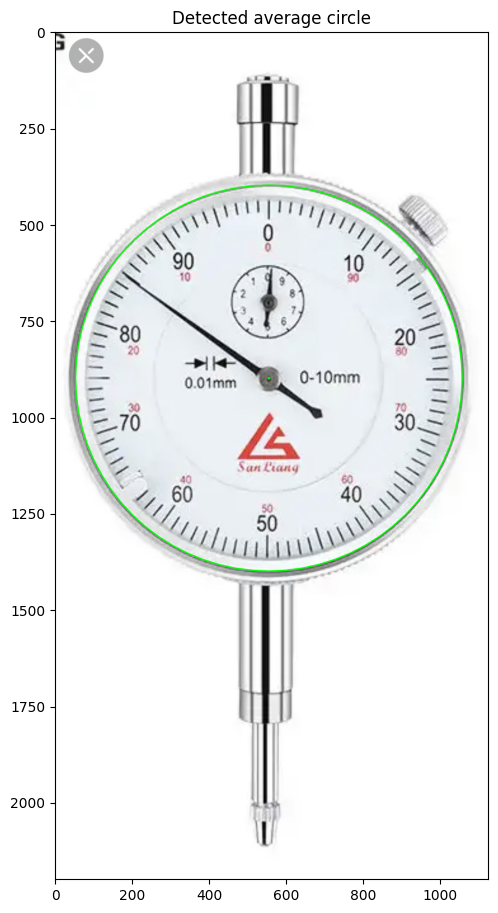

In [51]:
minDistance = round(originalHeight/2)
minR = round(originalWidth*0.2)

# minDistance = 1
# minR = 10

maxR = round(originalWidth)
circles = detect_circles(grayImage, originalWidth, originalHeight, minDistance, minR, maxR)

print(circles)
if circles is None:
    raise Exception("Cannot find any circles")

allDetectCircleResult = draw_circles(image, circles)
show_image_notebook(allDetectCircleResult, scale=1/200, title='All detected circles')



averageCircle = get_average_circle(circles)
detectCircleResult = draw_circles(image, np.array([averageCircle]))
show_image_notebook(detectCircleResult, scale=1/200, title='Detected average circle')


## Crop the image

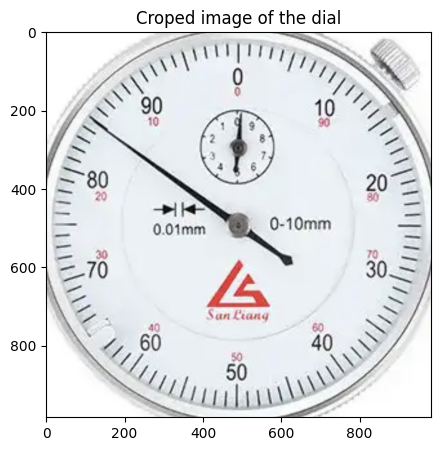

In [52]:
centerX, centerY, radius = averageCircle
padding = -10

upperLeft = (centerX-(radius+padding), centerY-(radius+padding))
lowerRight = (centerX+(radius+padding), centerY+(radius+padding))


dialImage = image[upperLeft[1] : (lowerRight[1]+1), upperLeft[0] : (lowerRight[0]+1), :]
dialGrayImage = cv2.cvtColor(dialImage, cv2.COLOR_BGR2GRAY)

show_image_notebook(dialImage, scale=1/200, title='Croped image of the dial')


## Detect the line of the pointer

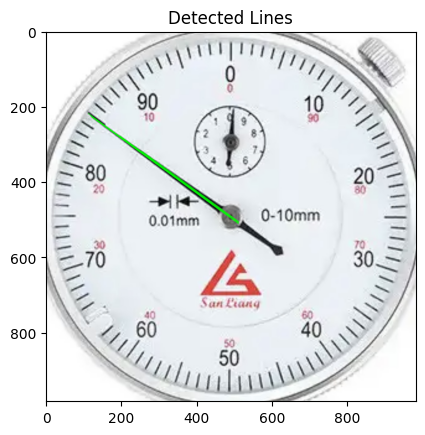

In [62]:
dialHeight, dialWidth = dialGrayImage.shape
center = np.around(np.array([dialWidth, dialHeight]) / 2).astype(int)

minLength = dialWidth // 4
maxGap = 0
lines = detect_lines(dialGrayImage, minLength, maxGap)

if lines is None:
    raise Exception("Cannot find any lines")

threshold = 5
validLines = filter_lines(lines, threshold, center)


detectLineResult = draw_lines(dialImage, validLines)

show_image_notebook(detectLineResult, scale=1, title='Detected Lines')


## Find the furthest point

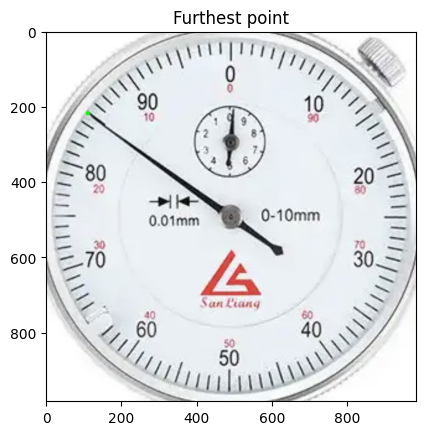

In [81]:
furthestPoint = find_furthest_point(validLines, center)

furthestPointResult = draw_point(dialImage, furthestPoint)

show_image_notebook(furthestPointResult, scale=1, title='Furthest point')


## Calculate the angle

In [83]:
angleDegree = calculate_pointer_angle(center, furthestPoint)
print(f"The pointer is at [{angleDegree}] degree")


The pointer is at [305.7221817699435] degree


## Read the dial

The reading of the gauge is [84.92].


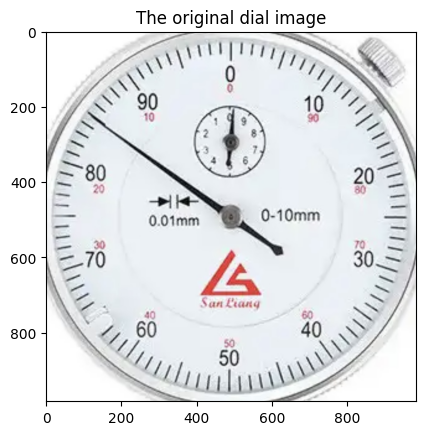

In [88]:
maxReading = 100
reading = read_dial(angleDegree, maxReading)

print(f"The reading of the gauge is [{reading}].")
show_image_notebook(dialImage, scale=1, title='The original dial image')


In [ ]:



# dialGrayImage = cv2.medianBlur(dialGrayImage, 9)
# dialGrayImage = cv2.GaussianBlur(dialGrayImage, (5, 5), 0)
# show_image(dialGrayImage)

# _, thresholdResultmage = cv2.threshold(dialGrayImage, thresh=150, maxval=255, type=cv2.THRESH_BINARY_INV)

# cannyEdgeDetectionResult = cv2.Canny(dialGrayImage, threshold1=50, threshold2=200, apertureSize=3, L2gradient=True)

# show_image(thresholdResultmage)

# rho: Distance resolution of the accumulator in pixels
# theta: Angle resolution of the accumulator in radians
# threshold: Accumulator threshold parameter
# minLineLength: Minimum line length
# maxLineGap: Maximum allowed gap between points on the same line
# lines = cv2.HoughLinesP(thresholdResultmage, rho=1, theta=np.pi/180, threshold=100, minLineLength=dialWidth//4, maxLineGap=0)





# print(lines)

# lines = np.squeeze(lines)
# print(lines)


# if lines is None:
#     raise Exception("Cannot find any lines")


# # assert(False)
# validLines = []
# distanceThreshold = 5
# for l in lines:
#     aLine = l[0]
#     p1 = np.array(aLine[:2])
#     p2 = np.array(aLine[2:])
   
#     distance = calcualte_distance_between_point_and_line(p1, p2, center)

#     if distance <= distanceThreshold:
#         # validTwoPoints = np.concatenate((p1, p2))
#         validTwoPoints = np.array([p1, p2])
#         validLines.append(validTwoPoints)

# print(validLines)


# validLines = np.stack(validLines)

  



# detectLineResult = draw_lines(detectLineResult, validLines)
# show_image(detectLineResult)